### Stock Market Prediction And Forecasting Using Stacked LSTM

### Import the Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
import datetime
import plotly
import cufflinks as cf
cf.go_offline()
%matplotlib inline

### Set Duration

In [2]:
start = datetime.datetime(2021, 1, 1)
#end = datetime.datetime(2022, 3, 1)

### Import the data using DataReader

In [3]:
df = data.DataReader("BTC-INR",'yahoo',start)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-31,2140422.25,2058085.375,2110904.75,2118790.25,3415796168900,2118790.25
2021-01-01,2163227.25,2104315.000,2118227.00,2147022.75,2977069369481,2147022.75
2021-01-02,2423382.25,2126340.000,2147191.25,2348254.25,4960436300944,2348254.25
2021-01-03,2529617.25,2342776.000,2348410.75,2395940.25,5749407146511,2395940.25
2021-01-04,2437574.75,2097177.500,2398054.25,2336819.00,5932217878548,2336819.00


In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-05-25,2337498.25,2279860.50,2297496.75,2290978.00,2133094711246,2290978.00
2022-05-26,2314071.75,2193052.00,2291165.25,2272028.00,2854807793298,2272028.00
2022-05-27,2278222.25,2200757.00,2270779.50,2224139.25,2842136506986,2224139.25
2022-05-28,2238693.00,2218467.00,2223754.75,2238693.00,2759594129443,2238693.00
2022-05-29,2284138.50,2241231.75,2253339.25,2276861.50,1328020586496,2276861.50


### Exploratory Data Analysis

#### Maximum Closing Rate

In [5]:
df.xs(key='Close',axis=1).max()

4994456.0

#### Visualization (Closing Rate)

In [6]:
df.xs(key='Close',axis=1).iplot()

#### 30-day Moving Average for Close Price

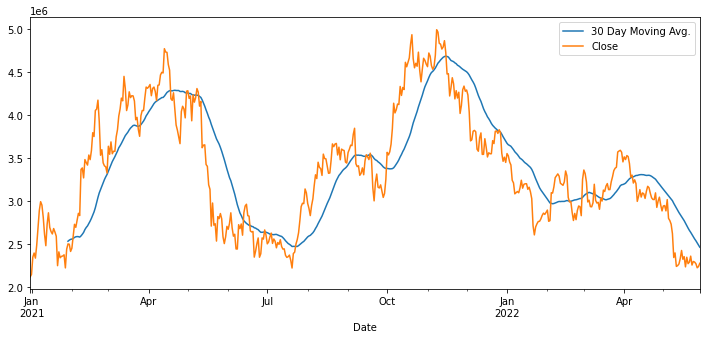

In [7]:
plt.figure(figsize=(12,5))
df['Close'].loc['2019-07-12':'2024-07-12'].rolling(window=30).mean().plot(label='30 Day Moving Avg.')
df['Close'].loc['2019-07-12':'2024-07-12'].plot(label='Close')
plt.legend()

In [8]:
df0 = df[['Open','High','Low','Close']].loc['2021-01-01':'2023-01-01']
df0.iplot(kind='candle')

In [9]:
df['Close'].loc['2020-12-30':'2022-12-30'].ta_plot(study='sma',periods=[9,18,27])

#### Let's Reset the Index to Close

In [10]:
df1=df.reset_index()['Close']

In [11]:
df1

0      2118790.25
1      2147022.75
2      2348254.25
3      2395940.25
4      2336819.00
          ...    
510    2290978.00
511    2272028.00
512    2224139.25
513    2238693.00
514    2276861.50
Name: Close, Length: 515, dtype: float64

#### Using MinMaxScaler

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
print(df1)

[[0.        ]
 [0.00981773]
 [0.07979509]
 [0.09637768]
 [0.07581853]
 [0.12810121]
 [0.19982642]
 [0.26875011]
 [0.30424746]
 [0.29037589]
 [0.24164778]
 [0.17249067]
 [0.1260742 ]
 [0.2126984 ]
 [0.2592205 ]
 [0.20009584]
 [0.18323939]
 [0.1735965 ]
 [0.19548343]
 [0.1812589 ]
 [0.16447183]
 [0.04524283]
 [0.1010586 ]
 [0.0772442 ]
 [0.08283325]
 [0.0845033 ]
 [0.08909528]
 [0.03615971]
 [0.11204188]
 [0.13322941]
 [0.13203638]
 [0.10279159]
 [0.11595567]
 [0.16363324]
 [0.21259799]
 [0.20040855]
 [0.22870148]
 [0.25709386]
 [0.24800779]
 [0.43479488]
 [0.44081271]
 [0.40046118]
 [0.47456324]
 [0.46237363]
 [0.45229483]
 [0.49304887]
 [0.47428608]
 [0.51105201]
 [0.58328641]
 [0.56802664]
 [0.67322471]
 [0.67893148]
 [0.71511927]
 [0.6290619 ]
 [0.4921423 ]
 [0.5145485 ]
 [0.46117703]
 [0.44916529]
 [0.44529289]
 [0.41993171]
 [0.52848301]
 [0.4959941 ]
 [0.54613588]
 [0.49820037]
 [0.50831847]
 [0.50793864]
 [0.56636685]
 [0.59550767]
 [0.65066411]
 [0.67927775]
 [0.72335623]
 [0.71

#### Splitting the Close data into Train and Test sets

In [14]:
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
training_size,test_size

(360, 155)

In [16]:
train_data

array([[0.        ],
       [0.00981773],
       [0.07979509],
       [0.09637768],
       [0.07581853],
       [0.12810121],
       [0.19982642],
       [0.26875011],
       [0.30424746],
       [0.29037589],
       [0.24164778],
       [0.17249067],
       [0.1260742 ],
       [0.2126984 ],
       [0.2592205 ],
       [0.20009584],
       [0.18323939],
       [0.1735965 ],
       [0.19548343],
       [0.1812589 ],
       [0.16447183],
       [0.04524283],
       [0.1010586 ],
       [0.0772442 ],
       [0.08283325],
       [0.0845033 ],
       [0.08909528],
       [0.03615971],
       [0.11204188],
       [0.13322941],
       [0.13203638],
       [0.10279159],
       [0.11595567],
       [0.16363324],
       [0.21259799],
       [0.20040855],
       [0.22870148],
       [0.25709386],
       [0.24800779],
       [0.43479488],
       [0.44081271],
       [0.40046118],
       [0.47456324],
       [0.46237363],
       [0.45229483],
       [0.49304887],
       [0.47428608],
       [0.511

In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape), print(y_train.shape)

(259, 100)
(259,)


(None, None)

In [20]:
print(X_test.shape), print(y_test.shape)

(54, 100)
(54,)


(None, None)

In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Stacked LSTM Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 2000,batch_size=32,verbose=1)

Epoch 1/2000
9/9 [==============================] - 7s 233ms/step - loss: 0.1213 - val_loss: 0.0686
Epoch 2/2000
9/9 [==============================] - 1s 92ms/step - loss: 0.0303 - val_loss: 0.0109
Epoch 3/2000
9/9 [==============================] - 1s 87ms/step - loss: 0.0238 - val_loss: 0.0393
Epoch 4/2000
9/9 [==============================] - 1s 83ms/step - loss: 0.0186 - val_loss: 0.0123
Epoch 5/2000
9/9 [==============================] - 1s 86ms/step - loss: 0.0166 - val_loss: 0.0220
Epoch 6/2000
9/9 [==============================] - 1s 79ms/step - loss: 0.0145 - val_loss: 0.0067
Epoch 7/2000
9/9 [==============================] - 1s 83ms/step - loss: 0.0137 - val_loss: 0.0125
Epoch 8/2000
9/9 [==============================] - 1s 85ms/step - loss: 0.0118 - val_loss: 0.0095
Epoch 9/2000
9/9 [==============================] - 1s 82ms/step - loss: 0.0125 - val_loss: 0.0057
Epoch 10/2000
9/9 [==============================] - 1s 85ms/step - loss: 0.0110 - val_loss: 0.0135
Epoch 11

### Lets Predict

In [27]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [28]:
# Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [29]:
### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

3627592.550365292

In [30]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

3066713.4685900104

### Let's Visualize the Predictions

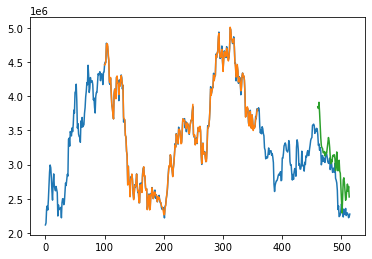

In [31]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [32]:
len(test_data)

155

In [33]:
x_input=test_data[230:].reshape(1,-1)
x_input.shape

(1, 0)

In [34]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [35]:
temp_input

[]

### Predictions for Next 30 Days

In [36]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [37]:
len(df1)

515

In [38]:
df3=scaler.inverse_transform(df1).tolist()

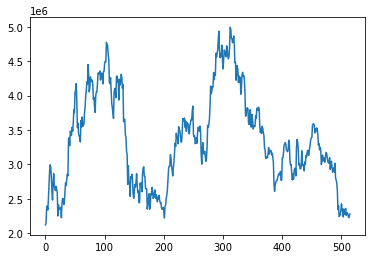

In [39]:
plt.plot(df3)

**CONCLUSION:** Here, these predictions say that 

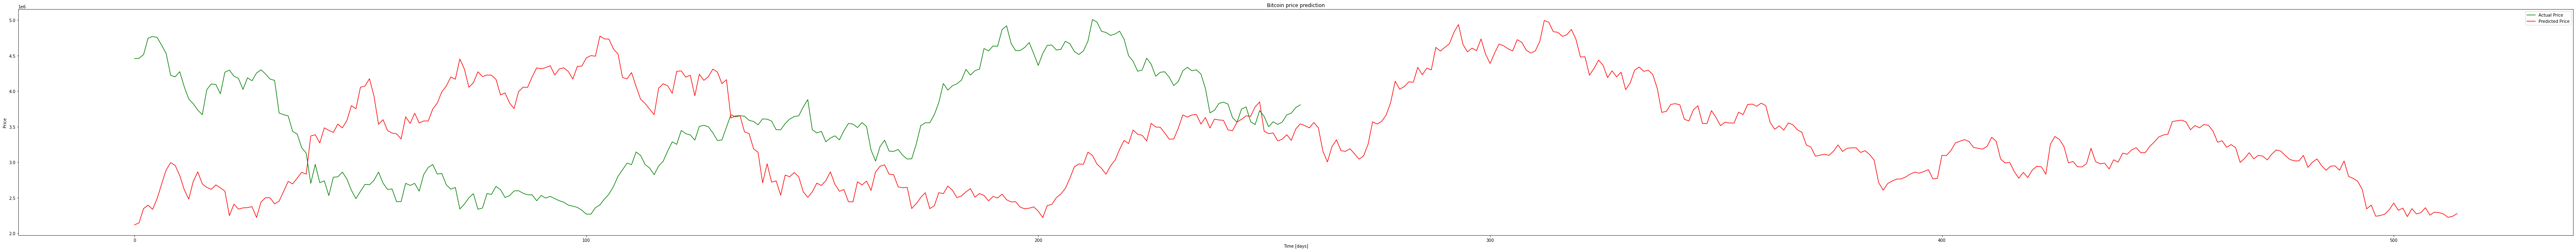

In [42]:
import matplotlib as mpl
plt.figure(figsize=(110,10))
plt.plot(train_predict, label="Actual Price", color='green')
plt.plot(df3, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

 
plt.show();